### Setup: Import Dependencies
Run the cell below to import the relevant dependencies.

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import functools

counter = 0

### Part 1: CMA-ES
Implement CMA-ES below.

In [12]:
def cmaes(fn, dim, num_iter=10):
  """Optimizes a given function using CMA-ES.

  Args:
    fn: A function that takes as input a vector and outputs a scalar value.
    dim: (int) The dimension of the vector that fn expects as input.
    num_iter: (int) Number of iterations to run CMA-ES.

  Returns:
    mu_vec: An array of size [num_iter, dim] storing the value of mu at each
      iteration.
    best_sample_vec: A list of length [num_iter] storing the function value
      for the best sample from each iteration of CMA-ES.
    mean_sample_vec: A list of length [num_iter] storing the average function
      value across samples from each iteration of CMA-ES.
  """
  # Hyperparameters
  sigma = 10
  population_size = 100
  p_keep = 0.10  # Fraction of population to keep
  noise = 0.25  # Noise added to covariance to prevent it from going to 0.

  # Initialize the mean and covariance
  mu = np.zeros(dim)
  cov = sigma**2 * np.eye(dim)

  mu_vec = []
  best_sample_vec = []
  mean_sample_vec = []
  for t in range(num_iter):
    # WRITE CODE HERE
    mu_vec.append(mu.copy())
    samples = np.random.multivariate_normal(mu,cov,population_size)
    fn_values = np.array([fn(sample) for sample in samples])

    best_sample_vec.append(np.max(fn_values))
    mean_sample_vec.append(np.mean(fn_values))

    num_keep = int(population_size*p_keep)
    best_indices = np.argsort(fn_values)[-num_keep:] 
    best_samples = samples[best_indices]
    
    mu = np.mean(best_samples, axis=0)
    cov = np.cov(best_samples, rowvar=False) + noise * np.eye(dim)
    


    # pass

  return np.array(mu_vec), best_sample_vec, mean_sample_vec

In the cell below, we've defined a simply function:
$$f(x) = -\|x - x^*\|_2^2 \quad \text{where} \quad x^* = [65, 49].$$
This function is optimized when $x = x^*$. Run your implementation of CMA-ES on this function, confirming that you get the correct solution.

In [13]:
def test_fn(x):
  goal = np.array([65, 49])
  return -np.sum((x - goal)**2)

mu_vec, best_sample_vec, mean_sample_vec = cmaes(test_fn, dim=2, num_iter=100)

Run the following cell to visualize CMA-ES.

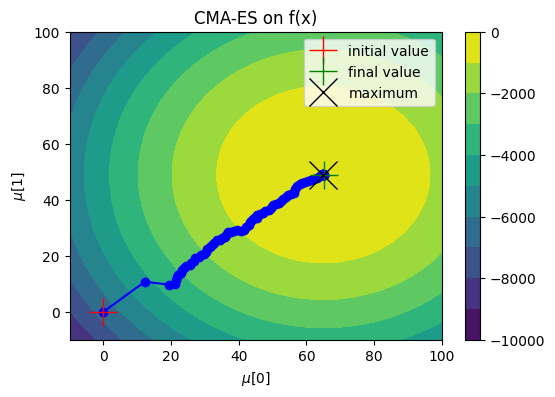

In [14]:
x = np.stack(np.meshgrid(np.linspace(-10, 100, 30), np.linspace(-10, 100, 30)), axis=-1)
fn_value = [test_fn(xx) for xx in x.reshape((-1, 2))]
fn_value = np.array(fn_value).reshape((30, 30))
plt.figure(figsize=(6, 4))
plt.contourf(x[:, :, 0], x[:, :, 1], fn_value, levels=10)
plt.colorbar()
mu_vec = np.array(mu_vec)
plt.title("CMA-ES on f(x)")
plt.xlabel("$\mu$[0]")
plt.ylabel("$\mu$[1]")
plt.plot(mu_vec[:, 0], mu_vec[:, 1], 'b-o')
plt.plot([mu_vec[0, 0]], [mu_vec[0, 1]], 'r+', ms=20, label='initial value')
plt.plot([mu_vec[-1, 0]], [mu_vec[-1, 1]], 'g+', ms=20, label='final value')
plt.plot([65], [49], 'kx', ms=20, label='maximum')
plt.legend()
plt.show()

Next, you will apply CMA-ES to a more complicating: maximizing the expected reward of a RL agent. The policy takes action LEFT with probability:
$$\pi(a = \text{LEFT} \mid s) = s \cdot w + b,$$
where $w \in \mathbb{R}^4$ and $b \in \mathbb{R}$ are parameters that you will optimize with CMA-ES. In the cell below, define a function that takes as input a single vector $x = (w, b)$ and the environment and returns the total (undiscounted) reward from one episode.

In [15]:
def _sigmoid(x):
  return 1 / (1 + np.exp(-x))

def _get_action(s, params):
  w = params[:4]
  b = params[4]
  p_left = _sigmoid(w @ s + b)
  a = np.random.choice(2, p=[p_left, 1 - p_left])
  return a

def rl_fn(params, env):
  global counter
  counter += 1
  assert len(params) == 5
  ## WRITE CODE HERE
  total_rewards = 0
  num_episodes = 5
  max_steps=500
  for _ in range(num_episodes):
    s, _ = env.reset()
    done = False
    steps = 0
    episode_reward = 0
    while not done and steps < max_steps:
      a = _get_action(s, params)
      s, r, done, truncated, _ = env.step(a)
      episode_reward += r
      steps += 1
      if truncated:
        done = True
    
    total_rewards += episode_reward
  total_rewards /= num_episodes
  if counter % 100 == 0:
    print(f"counter: {counter}, Mean rewards: {total_rewards:.1f}")
  return total_rewards

In [22]:
env = gym.make('CartPole-v0')

def evaluate_policy(params, env, num_episodes=1000):
    total_reward = 0
    for _ in range(num_episodes):
        s, _ = env.reset()
        done = False
        episode_reward = 0
        while not done:
            a = _get_action(s, params)
            s, r, done, truncated, _ = env.step(a)
            episode_reward += r
            if truncated:
                done = True
        total_reward += episode_reward
    return total_reward / num_episodes

policies = {
    'Policy 1': np.array([-1, -1, -1, -1, -1]), #double check
    'Policy 2': np.array([1, 0, 1, 0, 1]),
    'Policy 3': np.array([0, 1, 2, 3, 4])
}

print("="*50)
for name, params in policies.items():
    avg_reward = evaluate_policy(params, env, num_episodes=1000)
    print(f"{name} {params}: {avg_reward:.1f}")

Policy 1 [-1 -1 -1 -1 -1]: 15.7
Policy 2 [1 0 1 0 1]: 14.4
Policy 3 [0 1 2 3 4]: 9.4


The cell below applies your CMA-ES implementation to the RL objective you've defined in the cell above.

In [17]:
env = gym.make('CartPole-v0')
fn_with_env = functools.partial(rl_fn, env=env)
mu_vec, best_sample_vec, mean_sample_vec = cmaes(fn_with_env, dim=5, num_iter=10)

counter: 100, Mean rewards: 9.6
counter: 200, Mean rewards: 26.4
counter: 300, Mean rewards: 184.2
counter: 400, Mean rewards: 200.0
counter: 500, Mean rewards: 200.0
counter: 600, Mean rewards: 200.0
counter: 700, Mean rewards: 200.0
counter: 800, Mean rewards: 200.0
counter: 900, Mean rewards: 200.0
counter: 1000, Mean rewards: 200.0


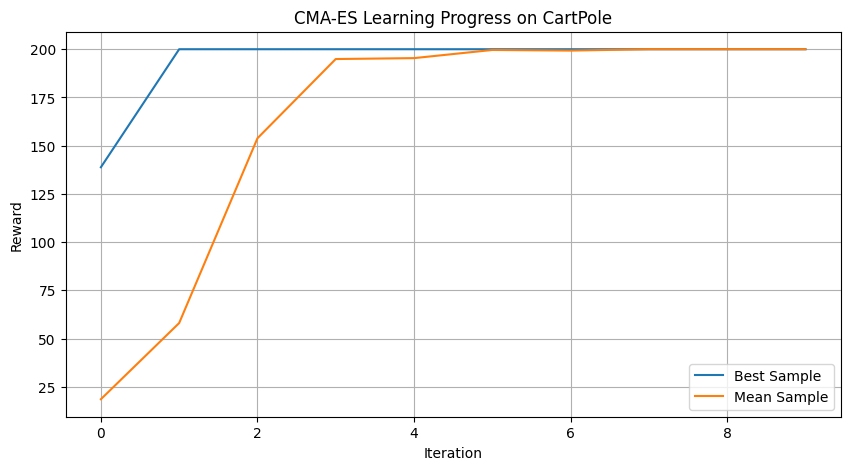

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(best_sample_vec, label='Best Sample')
plt.plot(mean_sample_vec, label='Mean Sample')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.title('CMA-ES Learning Progress on CartPole')
plt.legend()
plt.grid(True)
plt.show()